In [1]:
import fitsio as fio
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time as time

In [2]:
mem = fio.FITS('/lsst/troxel/y1a1/lgt5_member_mcal_combined.fits')[-1] # Member/shape catalog
clus = fio.FITS('/lsst/troxel/y1a1/y1a1_gold_1.0.3-d10-mof-001d_run_redmapper_v6.4.17_lgt5_desformat_catalog.fit')[-1] # Cluster catalog
cent = fio.FITS('/lsst/troxel/y1a1/central_member_shapes.fits')[-1] # Central/shape catalog
sat = fio.FITS('/lsst/troxel/y1a1/sat_member_shapes.fits')[-1] # Satellite/shape catalog

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # Use standard cosmological model

In [4]:
# Slice to the galaxies of specified catalog and cluster
def get_clus(catalog, clus_id):
    clus_mems = catalog.read()[np.in1d(catalog['MEM_MATCH_ID'].read(), clus_id, assume_unique=False)]
    
    return clus_mems

In [5]:
# Slice to the central galaxy of specified cluster
def get_cent(clus_id):
    clus_cent = get_clus(cent, clus_id)
    
    return clus_cent

In [6]:
# Slice to satellite galaxies of specified cluster
def get_sat(clus_id):
    clus_sat = get_clus(sat, clus_id)
    
    return clus_sat

In [7]:
# Slice to specified column of satellite galaxies
def get_sat_prop(clus_id, prop):
    mask = sat['MEM_MATCH_ID'].read()==clus_id
    sat_prop = sat[prop].read()[mask]
    
    return sat_prop

In [8]:
# Calculate comoving distance
def co_distance(z):
    co_distance = cosmo.comoving_distance(z)
    
    return co_distance

In [9]:
# Calculate angular diameter distance
def ad_distance(z):
    ad_distance = co_distance(z) / (z + np.ones(len(z)))
    
    return ad_distance

In [10]:
# Calculate angular separation
def separation(clus_id):
    cent_pos = SkyCoord(np.ones(len(get_clus(mem, clus_id)['RA']))*get_clus(cent, clus_id)['RA']*u.deg, np.ones(len(get_clus(mem, clus_id)['DEC']))*get_clus(cent, clus_id)['DEC']*u.deg, frame='icrs')
    sat_pos = SkyCoord(get_clus(mem, clus_id)['RA']*u.deg, get_clus(mem, clus_id)['DEC']*u.deg, frame='icrs')
    sep = cent_pos.separation(sat_pos)
    
    return sep

In [11]:
# Calculate 3D distance
def distance_3d(clus_id):
    cent_distance = ad_distance(get_clus(cent, clus_id)['Z'])
    sat_distance = ad_distance(get_clus(mem, clus_id)['Z'])
    cent_pos = SkyCoord(np.ones(len(get_clus(mem, clus_id)['RA']))*get_clus(cent, clus_id)['RA']*u.deg, np.ones(len(get_clus(mem, clus_id)['DEC']))*get_clus(cent, clus_id)['DEC']*u.deg, distance=np.ones(len(get_clus(mem, clus_id)['Z']))*cent_distance, frame='icrs')
    sat_pos = SkyCoord(get_clus(mem, clus_id)['RA']*u.deg, get_clus(mem, clus_id)['DEC']*u.deg, distance=sat_distance, frame='icrs')
    sep_3d = cent_pos.separation_3d(sat_pos)
    
    return sep_3d

In [12]:
# Approximate 3D distance
def approx_distance(clus_id):
    ang_sep = separation(clus_id)
    cent_distance = ad_distance(get_clus(cent, clus_id)['Z'])
    approx_distance = np.radians(ang_sep) * cent_distance
    
    return approx_distance

In [13]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(e2, e1)/2
    
    return alpha

In [14]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop):
    sat_prop_full = sat[prop].read()
    sat_id, counts = np.unique(sat['MEM_MATCH_ID'].read(), return_counts=True)
    new_array = np.zeros((231185,308))
    k = 0
    for i in range(231185):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [15]:
# Calculate satellite angular position for all satellite galaxies
def sat_ang_pos():
    sat_ra = np.radians(sat_prop('RA'))
    sat_dec = np.radians(sat_prop('DEC'))
    cent_ra = np.radians(cent['RA'].read().reshape(231185,-1))
    cent_dec = np.radians(cent['DEC'].read().reshape(231185,-1))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    sat_ang = np.arctan2(y, x)
    
    return sat_ang

In [16]:
# Calculate central galaxy alignment angle for all viable clusters
def cent_gal_ang():
    sat_pos_ang = sat_ang_pos()
    cent_pos_ang = pos_ang(cent['e1'].read(), cent['e2'].read()).reshape(231185,-1)
    theta = sat_pos_ang - cent_pos_ang
    theta = np.arcsin(np.absolute(np.sin(theta)))
    theta = np.degrees(theta)
    
    return theta

In [17]:
central_ang = cent_gal_ang()
mask = ~np.isnan(central_ang)
central_ang = central_ang[mask]

In [70]:
sort = np.argsort(central_ang)
central_ang = central_ang[sort]

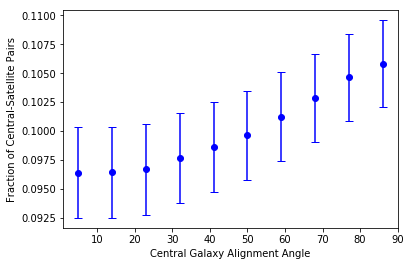

In [89]:
n, bins = np.histogram(central_ang, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = central_ang[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+5., n/4537863, yerr=new_array, fmt='bo', capsize=4)
plt.xlabel('Central Galaxy Alignment Angle')
plt.ylabel('Fraction of Central-Satellite Pairs')
plt.show()

In [37]:
# Count satellite galaxies in each quadrant with specified axis angle
def quad_counts(theta):
    sat_pos = np.degrees(sat_ang_pos()) + 180
    theta = theta + 180
    q1_count = np.sum(np.logical_and(np.less_equal(theta-180, sat_pos), np.less(sat_pos, theta-90)), axis=1)
    q2_count = np.sum(np.logical_and(np.less_equal(theta-90, sat_pos), np.less(sat_pos, theta)), axis=1)
    q3_count = np.sum(np.logical_and(np.less_equal(theta, sat_pos), np.less(sat_pos, theta+90)), axis=1)
    q4_count = np.sum(np.logical_and(np.less_equal(theta+90, sat_pos), np.less(sat_pos, theta+180)), axis=1)
    
    return np.array([q1_count, q2_count, q3_count, q4_count])

In [38]:
# Calculate chi squared for quadrant counts of each cluster with specified axis angle
def q_chisq(theta):
    q_i = quad_counts(theta)
    chi_sq, p = stats.chisquare(q_i)
    
    return chi_sq

In [39]:
# Make array of chi squared values for n angles between 0 and 90 degrees
def q_array(n):
    new_array = np.zeros((n, 231185))
    for i in range(n):
        chisq_i = q_chisq(90*i/n)
        new_array[i] = chisq_i
    
    return new_array

In [40]:
# Approximate cluster position angles by finding the least chi squared values
def q_pa(n):
    chisq_array = q_array(n)
    chi_sort = np.argmin(chisq_array, axis=0)
    n_ang = np.arange(n)*90/n
    thetas = n_ang[chi_sort]
    
    return thetas

In [56]:
q_clus_pa = q_pa(18)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_10/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_10/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_10/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_10/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_10/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel_

In [73]:
sort = np.argsort(q_clus_pa)
q_clus_pa = q_clus_pa[sort]

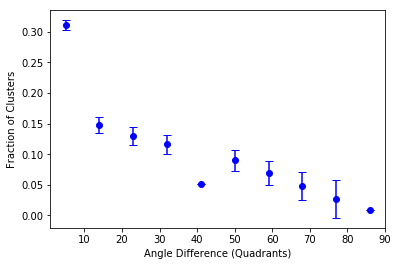

In [92]:
n, bins = np.histogram(q_clus_pa, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = q_clus_pa[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+5., n/231185, yerr=new_array, fmt='bo', capsize=4)
plt.xlabel('Angle Difference (Quadrants)')
plt.ylabel('Fraction of Clusters')
plt.show()

In [78]:
def mom_2(p, x, y, a, b):
    mom_top = p*a*b/(x**2+y**2)
    mom_sum = np.sum(np.nan_to_num(mom_top), axis=1)/np.sum(np.nan_to_num(p), axis=1)
    
    return mom_sum

In [79]:
def clus_pa():
    sat_ra = sat_prop('RA')
    sat_dec = sat_prop('DEC')
    cent_ra = cent['RA'].read().reshape((231185,-1))
    cent_dec = cent['DEC'].read().reshape((231185,-1))
    p_i = sat_prop('P') * sat_prop('PFREE')
    x_i = sat_ra - cent_ra
    y_i = sat_dec - cent_dec
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    beta = np.arctan2(2*m_xy, (m_xx-m_yy)) / 2
    
    return beta

In [80]:
def alignment():
    cent_pa = pos_ang(cent['e1'].read(), cent['e2'].read())
    clust_pa = clus_pa()
    theta = cent_pa - clust_pa
    theta = np.arcsin(np.absolute(np.sin(theta)))
    theta = np.degrees(theta)
    
    return theta

In [81]:
stat_align = alignment()

In [83]:
sort = np.argsort(stat_align)
stat_align = stat_align[sort]

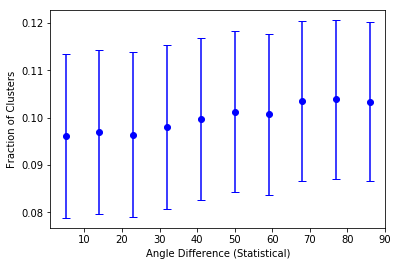

In [90]:
n, bins = np.histogram(stat_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = stat_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+5., n/231185, yerr=new_array, fmt='bo', capsize=4)
plt.xlabel('Angle Difference (Statistical)')
plt.ylabel('Fraction of Clusters')
plt.show()

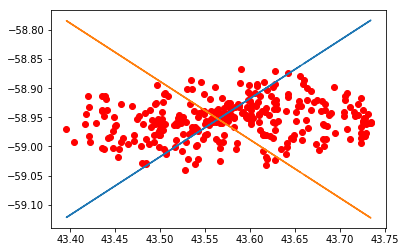

In [87]:
x_cent = get_cent(1)['RA']
y_cent = get_cent(1)['DEC']
x = get_clus(mem, 1)['RA']
y = get_clus(mem, 1)['DEC']
plt.plot(x, y, 'ro', x, (x-x_cent)+y_cent, x, -(x-x_cent)+y_cent)
plt.show()